In [2]:
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.1 MB/s eta 0:00:0000:0100:01


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import pickle

In [4]:
fake = pd.read_csv("/kaggle/input/fake-news-detection/Fake.csv")
true = pd.read_csv("/kaggle/input/fake-news-detection/True.csv")
print('Fake news data: ',fake.shape)
print('True news data:',true.shape)

Fake news data:  (23481, 4)
True news data: (21417, 4)


In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


### Combinding two data to one

In [7]:
data = pd.concat([fake, true], axis=0)
data

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


### Shuffling data

In [8]:
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True) 
data.head()

,title,text,subject,date
0,Cambodia's opposition braces for Supreme Court...,PHNOM PENH (Reuters) - Cambodia s Supreme Cour...,worldnews,"November 16, 2017"
1,Panama recalls EU ambassador over tax haven list,PANAMA CITY (Reuters) - Panama recalled its am...,worldnews,"December 6, 2017"
2,U.S. intelligence chiefs call Russia 'major' c...,WASHINGTON (Reuters) - Russia is a major threa...,politicsNews,"January 5, 2017"
3,BREAKING! Refugee Terrorist Coverup: Obama’s D...,Federal lawmakers are investigating how a form...,politics,"Mar 9, 2017"
4,HAWK OR NOT? Is Trump Expanding the Wars?,"So once again, here we are. A new President mu...",Middle-east,"July 3, 2017"


### Removing unwanted data before training ML models

In [9]:
data = data.drop(['title', 'subject', 'date'], axis=1)
data.head()

,text
0,PHNOM PENH (Reuters) - Cambodia s Supreme Cour...
1,PANAMA CITY (Reuters) - Panama recalled its am...
2,WASHINGTON (Reuters) - Russia is a major threa...
3,Federal lawmakers are investigating how a form...
4,"So once again, here we are. A new President mu..."


### Modifying news texts by removing unnecessary words and other characters

In [10]:
import re

def process_news(text):
    text = text.lower()
    text = re.sub(r'https?://S+ | www\.\S+', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    words=[]
    for i in text:
        if i not in string.punctuation:
            words.append(i)
    return ''.join(words)


data['text'] = data['text'].apply(process_news)
data['text'].head()

0    phnom penh reuters  cambodia s supreme court o...
1    panama city reuters  panama recalled its ambas...
2    washington reuters  russia is a major threat t...
3    federal lawmakers are investigating how a form...
4    so once again here we are a new president must...
Name: text, dtype: object

In [11]:
from sklearn.model_selection import train_test_split
### Separating the data 80:20 for training and testing
x = data['text']
# y = data['class']
xtrain, xtest = train_test_split(x, test_size=0.2)

In [12]:
xtrain

28844    tokyo reuters  a rapidly weakening typhoon lan...
10223    washingtoncairo reuters  five iraqi passengers...
26435    mexico city reuters  an indigenous woman backe...
19153    washington reuters  four us republican senator...
8252     mexico city reuters  mexico will reduce the pr...
                               ...                        
3024     donald trump is obsessed with himself so obses...
17280    a scheduled rally for 2016 republican presiden...
24870    the senate session is coming to a close for th...
1083     islamabad reuters  a pakistani court issued an...
36614    we ve noticed a trend across america that s di...
Name: text, Length: 35918, dtype: object

### Before training, converting text to vector form

In [13]:
# from sklearn.feature_extraction.text import TfidfVectorizer

vector = TfidfVectorizer()
xtrain = vector.fit_transform(xtrain)
xtest = vector.transform(xtest)

In [14]:
xtrain

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7494380 stored elements and shape (35918, 201355)>

### Apply PCA

In [15]:
### Applying principle component analysis (PCA) on the vectorized text to reduce it from high dimension to low dimension
from sklearn.decomposition import TruncatedSVD

# Using TruncatedSVD instead of PCA
svd = TruncatedSVD(n_components=2, random_state=42)
xtrain = svd.fit_transform(xtrain)
xtest = svd.transform(xtest)

In [16]:
xtrain.shape

(35918, 2)

### Implementing K-means

In [17]:
# implementing k-means algorithm and finding the optimal number of clusters for k-means algorithm
wcss = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans.fit(xtrain)
  wcss.append(kmeans.inertia_)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

### Plotting the elbow point graph of the k-means algorithms

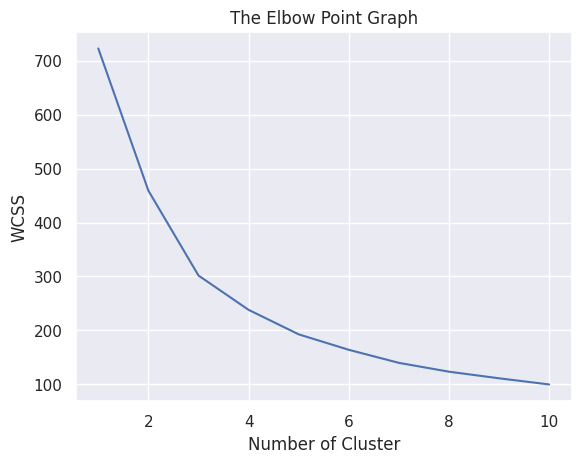

In [18]:
sns.set_theme()
plt.plot(range(1,11), wcss)

plt.title("The Elbow Point Graph")
plt.xlabel("Number of Cluster")
plt.ylabel("WCSS")
plt.show()

In this elbow graph, we can see that after n_clusters=6, the graph is getting stabilized. Therefore, the optimal number of cluster for k-means is 6

### Training the model with the optimal number of clusters found in the elbow point graph

In [19]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans.fit_predict(xtrain)
kmeans_labels = kmeans.labels_
print(kmeans_labels)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[3 5 1 ... 0 3 0]


### Plotting the clusters as a scatter plot

Text(0.5, 1.0, 'Kmeans Clustering')

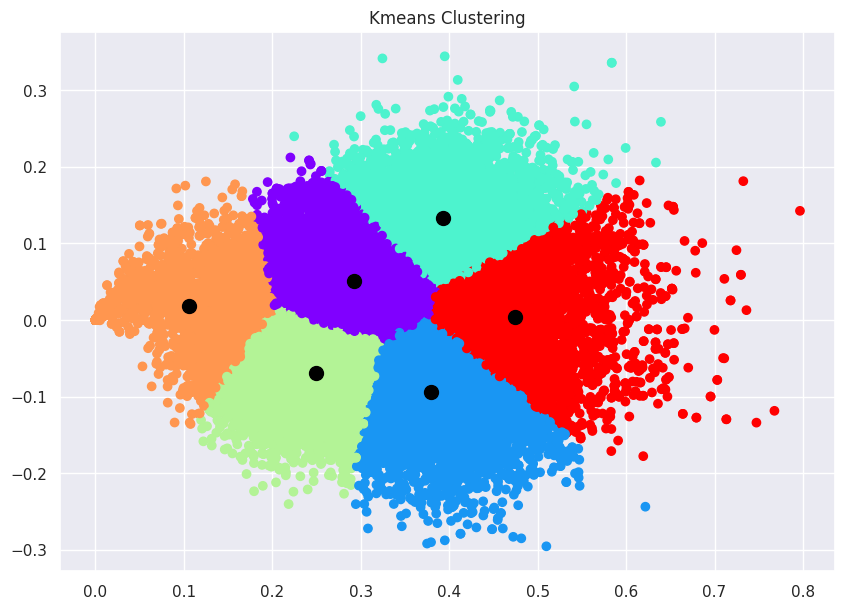

In [20]:
plt.figure(figsize=(10, 7))
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=kmeans_labels, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='centroid')
plt.title('Kmeans Clustering')

### Checking the quality of kmeans

In [21]:
# checking the quality of cluster of kmeans with the help of silhouette score
from sklearn.metrics import silhouette_score

silhouette_score_kmeans = silhouette_score(xtrain, kmeans_labels)
silhouette_score_kmeans

0.3292631224630887

### Implementing Agglomerative Hierarical Clustering Algorithm

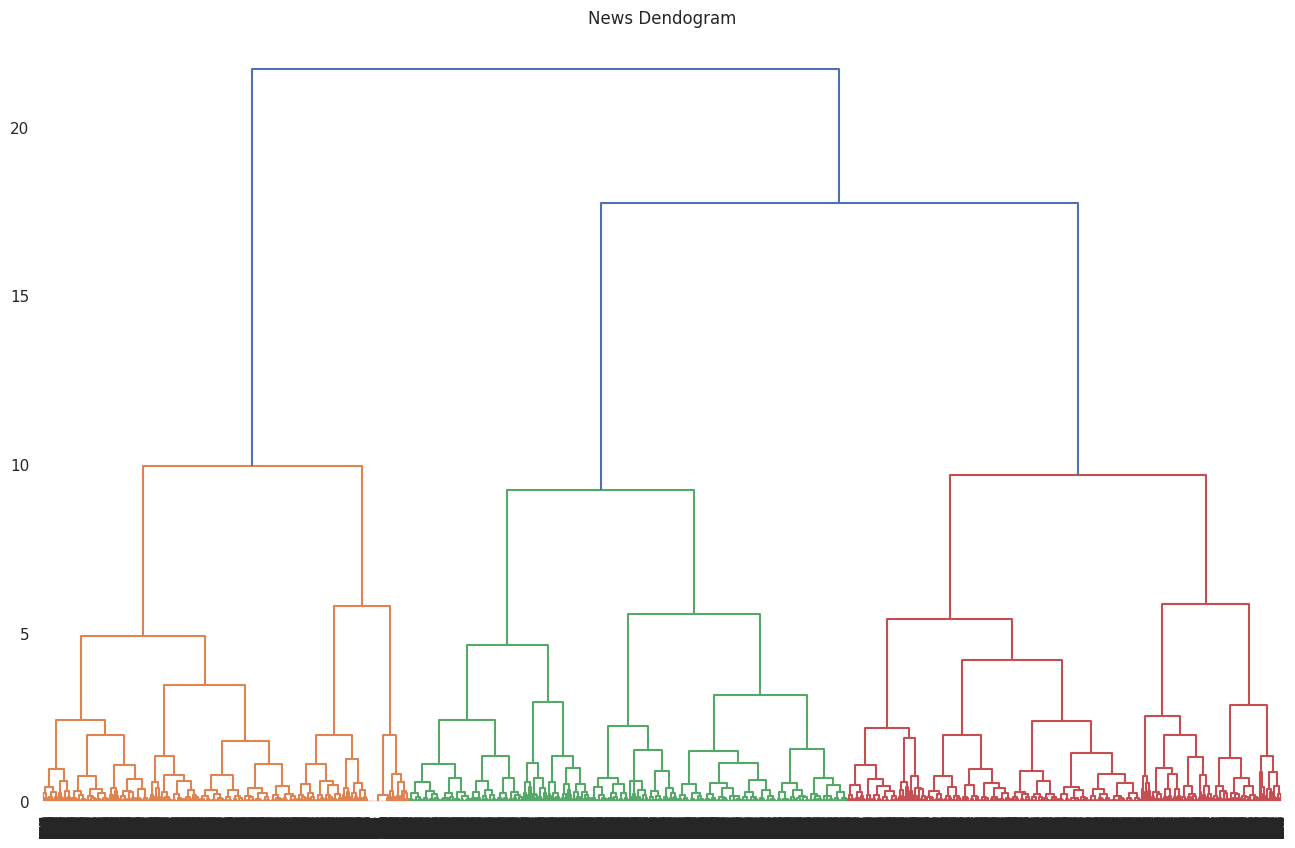

In [22]:
### Implementing Agglomerative Hierarical Clustering Algorithm and finding the optimal number fo clusters for agglomerative hierarical clustering algorithm
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(16, 10))
plt.title('News Dendogram')

dend = shc.dendrogram(shc.linkage(xtrain, method='ward'))

By cutting the dendrogram horizontally along the longest line, we get 3 clusters, indicating that the optimal number of clusters for agglomerative clustering is 3.

In [23]:
# Training the model with the optimal number of clusters found from the dendogram
from sklearn.cluster import AgglomerativeClustering
cluster_hierarcial = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')

In [24]:
cluster_hierarcial.fit_predict(xtrain)

array([0, 1, 1, ..., 2, 0, 2])

### Plotting the clusters as a scatter plot

Text(0.5, 1.0, 'Agglomerative Hierarical Clustering')

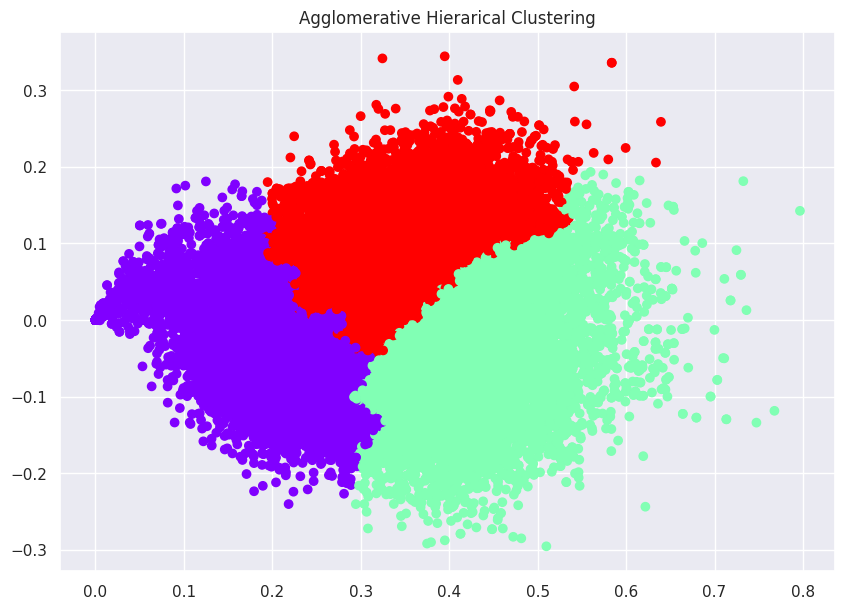

In [25]:
plt.figure(figsize=(10,7))
hiearachy_labels = cluster_hierarcial.labels_
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=hiearachy_labels, cmap='rainbow')
plt.title('Agglomerative Hierarical Clustering')

### Checking the quality of the cluster of agglomerative hierarical

In [26]:
silhouette_score_hierarchy = silhouette_score(xtrain, hiearachy_labels)
silhouette_score_hierarchy

0.3290818094627077

### Implementing K-mediods

In [27]:
from sklearn_extra.cluster import KMedoids

wcss = []

for i in range(1, 11):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state=42)
    kmedoids.fit(xtrain)
    wcss.append(kmedoids.inertia_)

In [28]:
wcss

[4510.067500431694,
 3580.9885975963834,
 2892.238151711994,
 2584.6143737019547,
 2337.1316056847963,
 2161.9132397403,
 2006.913457777093,
 1878.095255339178,
 1789.5217521745476,
 1705.2581548193289]

### Plotting the elbow point graph of the k-medoids algorithm

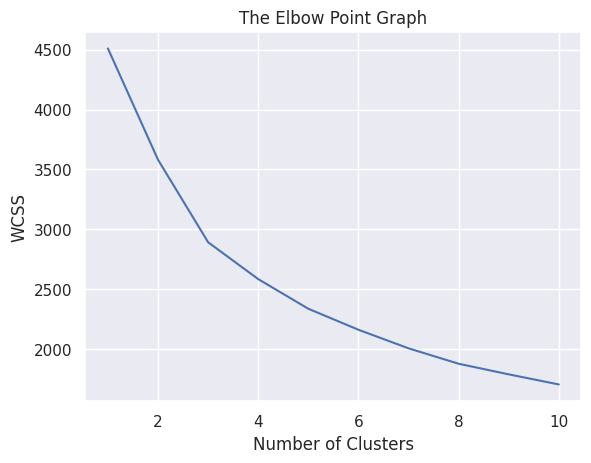

In [29]:
sns.set()

plt.plot(range(1, 11), wcss)

plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.show()

In this elbow graph, we can see that after n_clusters=5, the graph is getting stabilized. Therefore, the optimal number of clusters for k-medoid is 5

### Training the model with the optimal number of clusters found in the elbow point graph

In [30]:
kmedoids = KMedoids(n_clusters=3, random_state=42)

In [31]:
kmedoids.fit_predict(xtrain)

/opt/conda/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


array([0, 1, 1, ..., 1, 0, 2])

In [32]:
kmediod_labels = kmedoids.labels_
kmediod_labels

array([0, 1, 1, ..., 1, 0, 2])

### Plotting the clusters as a scatter plot

Text(0.5, 1.0, 'Kmedoid Clustering')

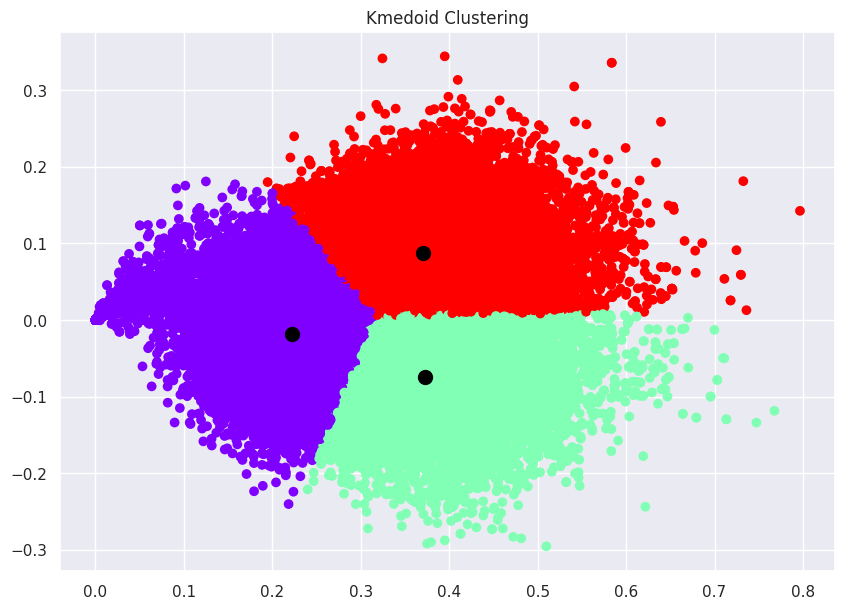

In [33]:
plt.figure(figsize=(10, 7))
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=kmediod_labels, cmap='rainbow')
plt.scatter(kmedoids.cluster_centers_[:, 0], kmedoids.cluster_centers_[:, 1], s=100, c='black', label='centroid')
plt.title('Kmedoid Clustering')

### Checking the quality of the cluster of kmedoid with the help of silhouette score

In [34]:
silhouette_score_kmedoid = silhouette_score(xtrain, kmediod_labels)
silhouette_score_kmedoid

0.362473158871572

### Creating a table of the silhouette score of the three algorithm for better comparison

In [35]:
silhoutte_score_df = pd.DataFrame({
    'Algorithm': ['k-means Clustering', 'k-medoids Clustering', 'Agglomerative Hierarical Clustering'],
    'Silhouette Score': [silhouette_score_kmeans, silhouette_score_kmedoid, silhouette_score_hierarchy]
})

In [36]:
silhoutte_score_df

,Algorithm,Silhouette Score
0,k-means Clustering,0.329263
1,k-medoids Clustering,0.362473
2,Agglomerative Hierarical Clustering,0.329082


Text(0.5, 1.0, 'Silhouette Score of each Algorithm')

<Figure size 1200x800 with 0 Axes>

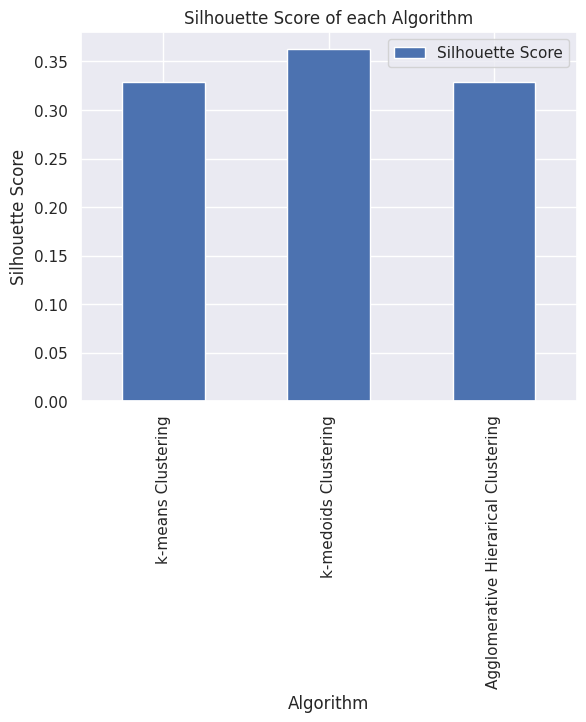

In [37]:
plt.figure(figsize=(12, 8))

silhoutte_score_df.plot(kind='bar', x='Algorithm')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score of each Algorithm')

### Conclusion
From the table and the graph, it is clear that the silhouette score of Agglomerative Hierarical Clustering is highest among the three indicating that it is the best clustering algorithm for our use case.

Therefore, for this project, THE OPTIMAL NUMBER OF CLUSTERS IS 3.

### Testing the model with sample data

##### Creating some sample data

In [38]:
sample_data_true = 'The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.'
sample_data_false = 'Health care reform legislation is likely to mandate free sex change surgeries.'
sample_data_half_true = 'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.'
sample_data_mostly_true = 'Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."'
sample_data_barely_true = 'Jim Dunnam has not lived in the district he represents for years now.'
sample_data_pants_fire = 'In the case of a catastrophic event, the Atlanta-area offices of the Centers for Disease Control and Prevention will self-destruct.'

### Pre-processing the sample

In [39]:
sample_data_true_preproccessed = process_news(sample_data_true)
sample_data_false_preproccessed = process_news(sample_data_false)
sample_data_half_true_preproccessed = process_news(sample_data_half_true)
sample_data_mostly_true_preproccessed = process_news(sample_data_mostly_true)
sample_data_barely_true_preproccessed = process_news(sample_data_barely_true)
sample_data_pants_fire_preproccessed = process_news(sample_data_pants_fire)

### Vectorizing the sample datas

In [40]:
sample_data_true_vectorized = vector.transform([sample_data_true_preproccessed]).toarray()
sample_data_false_vectorized = vector.transform([sample_data_false_preproccessed]).toarray()
sample_data_half_true_vectorized = vector.transform([sample_data_half_true_preproccessed]).toarray()
sample_data_mostly_true_vectorized = vector.transform([sample_data_mostly_true_preproccessed]).toarray()
sample_data_barely_true_vectorized = vector.transform([sample_data_barely_true_preproccessed]).toarray()
sample_data_pants_fire_vectorized = vector.transform([sample_data_pants_fire_preproccessed]).toarray()

### Applying PCA on the sample datas

In [41]:
sample_data_true_pca = svd.transform(sample_data_barely_true_vectorized)
sample_data_false_pca = svd.transform(sample_data_false_vectorized)
sample_data_half_true_pca = svd.transform(sample_data_half_true_vectorized)
sample_data_mostly_true_pca = svd.transform(sample_data_mostly_true_vectorized)
sample_data_barely_true_pca = svd.transform(sample_data_barely_true_vectorized)
sample_data_pants_fire_pca = svd.transform(sample_data_pants_fire_vectorized)

### Using K-Means Algorithm to make prediction on SIngle Input

In [42]:
kmeans = KMeans(n_clusters = 3, init='k-means++', random_state=42)
kmeans.fit_predict(xtrain)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 1, 1, ..., 1, 0, 2], dtype=int32)

In [43]:
pred_single_data = kmeans.predict(sample_data_false_pca)

In [44]:
pred_single_data[0]

0

Here, 0 means the above news belongs to cluster number 0

### Using Agglomerative Clustering to make prediction on Multiple Input(three only)

In [45]:
input_data_one = 'The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.' 
input_data_two = 'Jim Dunnam has not lived in the district he represents for years now.'
input_data_three = 'Health care reform legislation is likely to mandate free sex change surgeries.'

#### NOTE: We can't take more than 3 inputs in the array because the number of clusters used to train the agglomerative clustering model is 3.

In [46]:
input_data_one_preproccessed = process_news(input_data_one)
input_data_two_preproccessed = process_news(input_data_two)
input_data_three_preproccessed = process_news(input_data_three)

In [47]:
input_data_final = [input_data_one_preproccessed, input_data_two_preproccessed, input_data_three_preproccessed]
multiple_input_data_vectorized = vector.transform(input_data_final).toarray()
multiple_input_data_pca = svd.transform(multiple_input_data_vectorized)
pred_multiple_data = cluster_hierarcial.fit_predict(multiple_input_data_pca)

In [48]:
pred_multiple_data

array([2, 1, 0])

#### Here, [2, 1, 0] means the first news belongs to cluster number 2, the second news belongs to cluster number 1 and the third news belongs to cluster number 0.

### Generating pickle file of both the models, the pca and the vectorizer

In [49]:
pickle.dump(kmeans, open('modelkmeans.pkl', 'wb'))
pickle.dump(cluster_hierarcial, open('modelhierarchy.pkl', 'wb'))
pickle.dump(vector, open('vectorizer.pkl', 'wb'))
pickle.dump(svd, open('svd.pkl', 'wb'))

### Supervised Learning with clustered data

In [58]:
#Create new dataset from clustered data
x = xtrain
y = kmediod_labels.reshape(-1,1)
print('x', x.shape)
print('y', y.shape)

x (35918, 2)
y (35918, 1)


In [61]:
#Data splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print('xtrain',x_train.shape)
print('ytrain',y_train.shape)
print('xtest',x_test.shape)
print('ytest',y_test.shape)

xtrain (28734, 2)
ytrain (28734, 1)
xtest (7184, 2)
ytest (7184, 1)


In [62]:
#Modelling
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(x_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

## Logistic Regression

In [63]:
#Model accuracy
predition = LR.predict(x_test)
LR.score(x_test, y_test)

0.9945712694877505

In [65]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predition))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2421
           1       0.99      0.99      0.99      2429
           2       0.99      1.00      1.00      2334

    accuracy                           0.99      7184
   macro avg       0.99      0.99      0.99      7184
weighted avg       0.99      0.99      0.99      7184



## Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(x_train, y_train)

/tmp/ipykernel_30/3409762326.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(x_train, y_train)


RandomForestClassifier(random_state=0)

In [67]:
pred_rfc = RFC.predict(x_test)
RFC.score(x_test, y_test)

0.9969376391982183

In [68]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2421
           1       0.99      1.00      1.00      2429
           2       1.00      1.00      1.00      2334

    accuracy                           1.00      7184
   macro avg       1.00      1.00      1.00      7184
weighted avg       1.00      1.00      1.00      7184

